# Requirements

In [36]:
# Add as many imports as you need.
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LeakyReLU, LSTM, BatchNormalization
from xgboost import XGBClassifier
from tensorflow.keras.optimizers import Adam

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [2]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('climate-data.csv')
data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [3]:
data.set_index(keys=['date'], inplace=True)

In [4]:
data.sort_index(inplace=True)

In [5]:
data

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


Explore the dataset using visualizations of your choice.

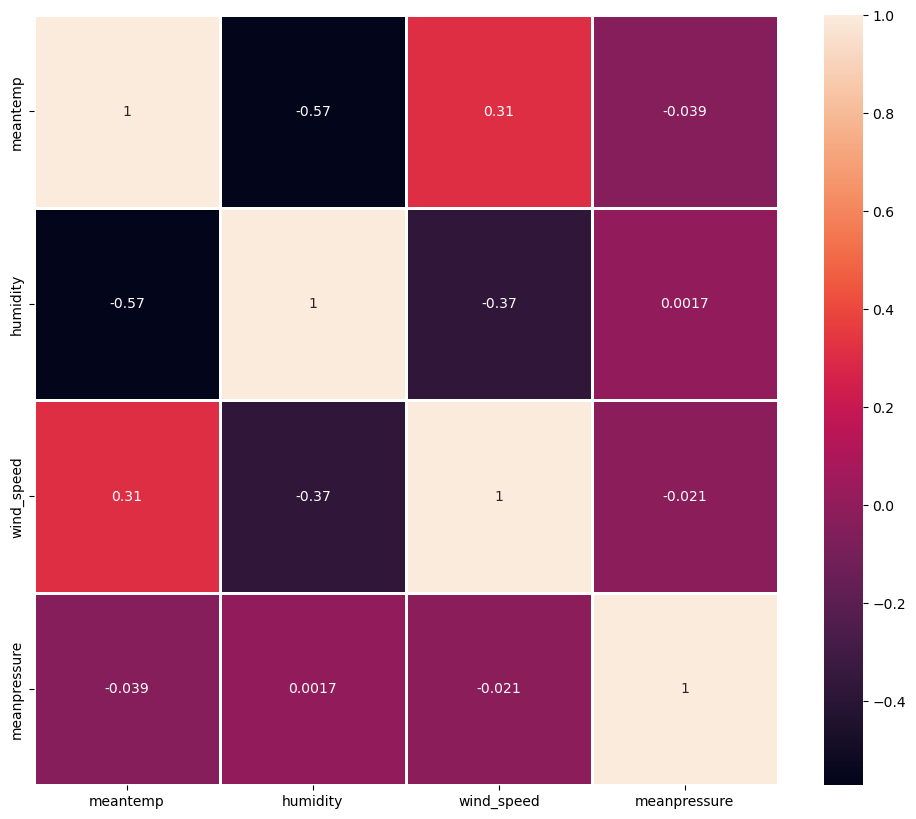

In [6]:
# Write your code here. Add as many boxes as you need.
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, linewidths=2)
plt.show()

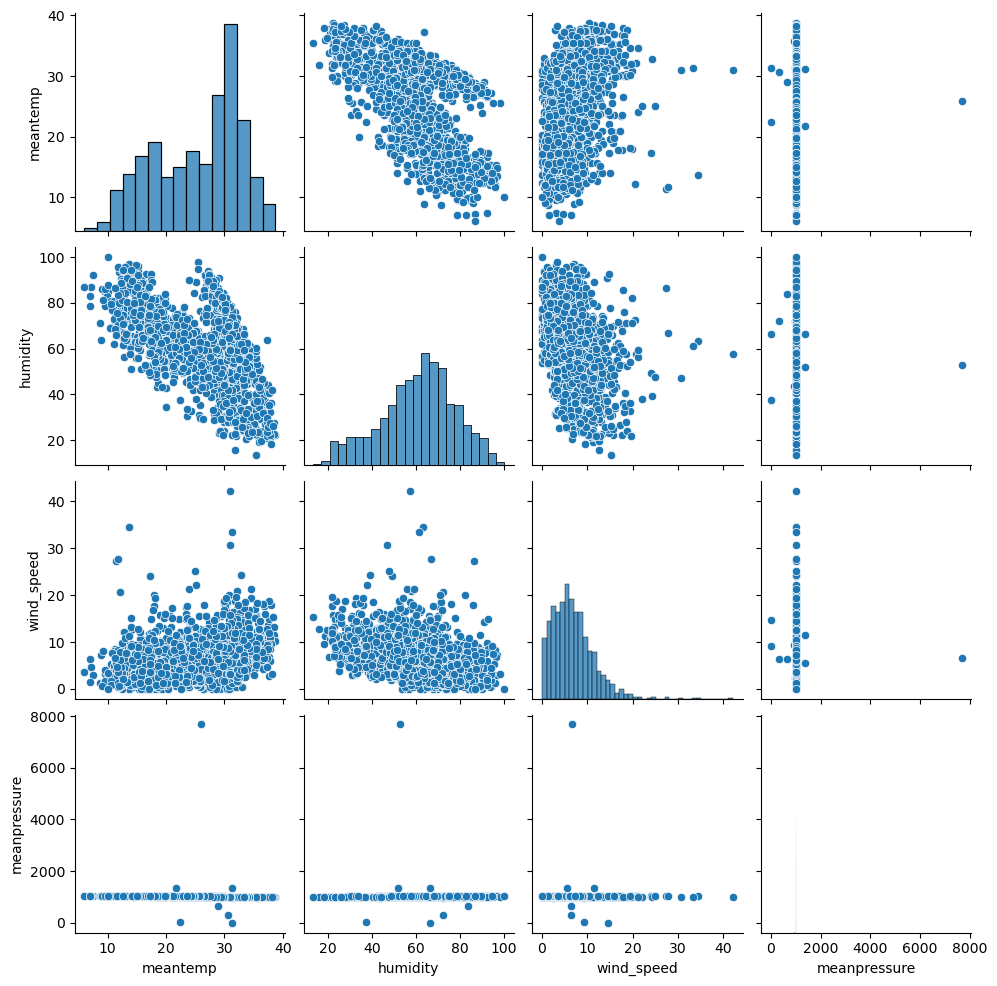

In [7]:
sns.pairplot(data)
plt.show()

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [8]:
# Write your code here. Add as many boxes as you need.
data.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [9]:
feautre_to_lag = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

for feature in feautre_to_lag:
    for lag in [1,2,3]:
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

In [10]:
data = data.dropna()

In [11]:
data.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_lag1,meantemp_lag2,meantemp_lag3,humidity_lag1,humidity_lag2,humidity_lag3,wind_speed_lag1,wind_speed_lag2,wind_speed_lag3,meanpressure_lag1,meanpressure_lag2,meanpressure_lag3
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.000000,87.000000,92.000000,84.500000,4.633333,2.980000,0.000000,1018.666667,1017.800000,1015.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.400000,71.333333,87.000000,92.000000,1.233333,4.633333,2.980000,1017.166667,1018.666667,1017.800000
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,8.666667,7.166667,86.833333,71.333333,87.000000,3.700000,1.233333,4.633333,1016.500000,1017.166667,1018.666667
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,6.000000,8.666667,82.800000,86.833333,71.333333,1.480000,3.700000,1.233333,1018.000000,1016.500000,1017.166667
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,6.000000,78.600000,82.800000,86.833333,6.300000,1.480000,3.700000,1020.000000,1018.000000,1016.500000


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [12]:
# Write your code here. Add as many boxes as you need.
target = 'meantemp'
X = data.drop([target], axis=1)
X
Y = data[target]
Y

date
2013-01-04     8.666667
2013-01-05     6.000000
2013-01-06     7.000000
2013-01-07     7.000000
2013-01-08     8.857143
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1459, dtype: float64

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [14]:
# Write your code here. Add as many boxes as you need.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [15]:
# Write your code here. Add as many boxes as you need.
X_train.shape[0]

1313

In [16]:
X_train.shape[1] // 3

5

In [17]:
lag

3

In [18]:
X_train = X_train.reshape(X_train.shape[0], lag, (X_train.shape[1] // lag))
X_test = X_test.reshape(X_test.shape[0], lag, (X_test.shape[1] // lag))

In [19]:
(X_train.shape[1], X_train.shape[2])

(3, 5)

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [20]:
# Write your code here. Add as many boxes as you need.
model = Sequential([
    Input((X_train.shape[1], X_train.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32, activation="relu", return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="linear")
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,753 (120.13 KB)

 Trainable params: 30,561 (119.38 KB)

 Non-trainable params: 192 (768.00 B)

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [22]:
# Write your code here. Add as many boxes as you need.
model.compile(
    loss="mean_squared_error",
    optimizer=Adam(),
    metrics=["mean_squared_error"],
)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [23]:
# Write your code here. Add as many boxes as you need.
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    shuffle=False
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 634.8830 - mean_squared_error: 634.8830 - val_loss: 724.3986 - val_mean_squared_error: 724.3986
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 619.9670 - mean_squared_error: 619.9670 - val_loss: 709.7873 - val_mean_squared_error: 709.7873
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 606.9662 - mean_squared_error: 606.9662 - val_loss: 690.8245 - val_mean_squared_error: 690.8245
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 586.2871 - mean_squared_error: 586.2871 - val_loss: 665.3904 - val_mean_squared_error: 665.3904
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 560.8258 - mean_squared_error: 560.8258 - val_loss: 637.7257 - val_mean_squared_error: 637.7257
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 531.2598 - mean_squared_error: 531.2598 - val_loss: 605.8210 - val_mean_squared_error: 605.8210
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 496.3049 -

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

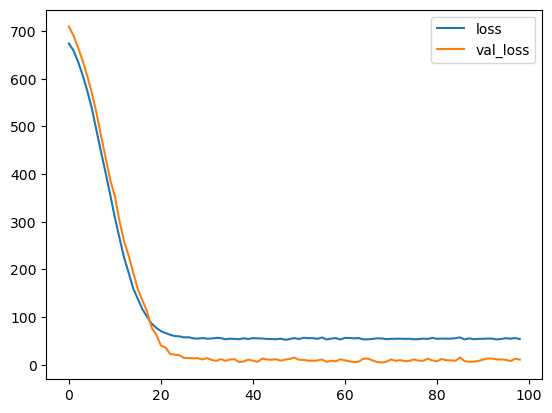

In [31]:
# Write your code here. Add as many boxes as you need.
sns.lineplot(history.history['loss'][1:], label='loss')
sns.lineplot(history.history['val_loss'][1:], label='val_loss')

Use the trained model to make predictions for the test set.

In [32]:
# Write your code here. Add as many boxes as you need.
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [37]:
# Write your code here. Add as many boxes as you need.
mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 8.057451814654792
Mean Absolute Error (MAE): 2.361557823435266
R² Score: 0.7525576617090042


Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

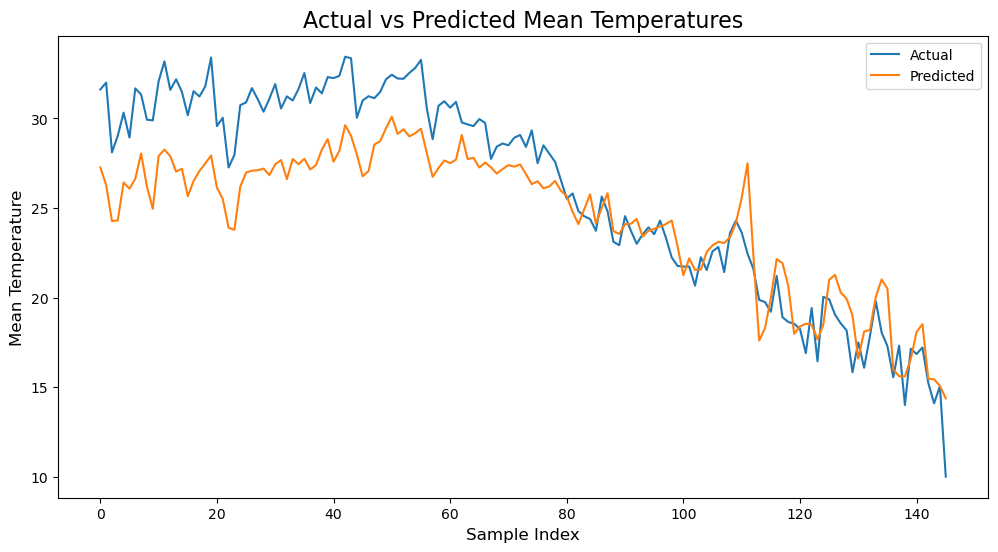

In [51]:
# Write your code here. Add as many boxes as you need.
y_test_array = Y_test.to_numpy().flatten() if hasattr(Y_test, 'to_numpy') else Y_test.flatten()
y_pred_array = y_pred.to_numpy().flatten() if hasattr(y_pred, 'to_numpy') else y_pred.flatten()

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=y_test_array, label='Actual')  # Actual values
sns.lineplot(data=y_pred_array, label='Predicted')  # Predicted values

# Add title and labels
plt.title("Actual vs Predicted Mean Temperatures", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Mean Temperature", fontsize=12)
plt.legend()
plt.show()

# Laboratory Exercise - Bonus Task (+ 2 points)

As a bonus task for this laboratory exercise, calculate the Simple Moving Average (SMA) and Weighted Moving Average (WMA) with 3 timesteps for `mean_temperature` over the past 1, 2, and 3 days:

- **SMA with 3 timesteps ($\text{SMA}_3$)** - the average of temperatures from the previous 3 days:  
  $SMA_3 = \frac{\text{mean\_temperaure}_{lag\_3} +\ \text{mean\_temperaure}_{lag\_2} +\ \text{mean\_temperaure}_{lag\_1}}{1\ +\ 1\ +\ 1}$.

- **WMA with 3 timesteps ($\text{WMA}_3$)** - a weighted average, giving more importance to recent days:  
  $WMA_3 = \frac{1\ \cdot\ \text{mean\_temperaure}_{lag\_3} +\ 2\ \cdot\ \text{mean\_temperaure}_{lag\_2} +\ 3\ \cdot\ \text{mean\_temperaure}_{lag_1}}{1\ +\ 2\ +\ 3}$.

Then use this indicators alongside the other features in the dataset to predict the `mean_temperaure`.

*Hint: Use the `rolling` method from `pandas`. Check the docs at the following link https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.*

In [52]:
# Write your code here. Add as many boxes as you need.
data['SMA_3'] = data['meantemp'].rolling(window=3).mean()

C:\Users\User\AppData\Local\Temp\ipykernel_34460\81015023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_3'] = data['meantemp'].rolling(window=3).mean()


In [ ]:
weights = [1,2,3]
data['WMA_3'] = data['meantemp'].rolling(window=3).apply(lambda x: np.dot)